<a href="https://colab.research.google.com/github/eadewusic/Time-Series-Forecasting/blob/main/Attention_Mechanism_LSTM_Eunice_Adewusi_air_quality_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade --force-reinstall --no-deps kaggle===1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username": "euniceadewusi", "key":"eef64544bac778940a260ba771f485b4"}')

!chmod 600 /root/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73249 sha256=e210fa58002a49874f724ce81601c5208f5a65b431898a98e708e25ba4c413f8
  Stored in directory: /root/.cache/pip/wheels/b5/23/bd/d33cbf399584fa44fa049711892d333954a50ed4b86948109e
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.5
    Uninstalling kaggle-1.7.4.5:
      Successfully uninstalled kaggle-1.7.4.5


In [3]:
# Downloading the Assignment

!kaggle competitions download -c assignment-1-time-series-forecasting-may-2025
!mkdir '/content/data'

!unzip -qo 'assignment-1-time-series-forecasting-may-2025.zip' -d '/content/data'

100% 839k/839k [00:00<00:00, 1.28MB/s]
100% 839k/839k [00:00<00:00, 1.28MB/s]


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Add, MultiHeadAttention, LayerNormalization
import tensorflow as tf
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os

In [5]:
# Load the datasets
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [6]:
# Print first few rows of the dataset to understand its structure
print("Training Data Overview:")
df_train.head(6)

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN
5,6,-1.442309,-1.840273,0.053790,-0.155751,-0.069353,-0.137667,2010-01-01 05:00:00,1.448138,-0.732019,-0.522096,NaN


It's obvious that pm2.5 column has missing values

In [7]:
# Training Data Info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ MB


Here, we see that the pm2.5 column has 28,755 non-null values out of 30,676 entries, indicating there are 1,921 missing values (30676 - 28755) in this column. All other columns are complete.

In [8]:
# view dataset columns
df_train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [9]:
# Ensure 'datetime' column is in datetime format
df_train['datetime'] = pd.to_datetime(df_train['datetime'])

df_test['datetime'] = pd.to_datetime(df_test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
df_train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
df_test.set_index('datetime', inplace=True)

'datetime' is converted to a datetime object, but then immediately moved out of the columns by setting it as the index. So it won't be a part of the features to be used in model training

In [10]:
# Statistics of dataset
df_train.describe()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,28755.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.793427
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,93.144433
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,29.000000
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,75.000000
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,142.000000
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000


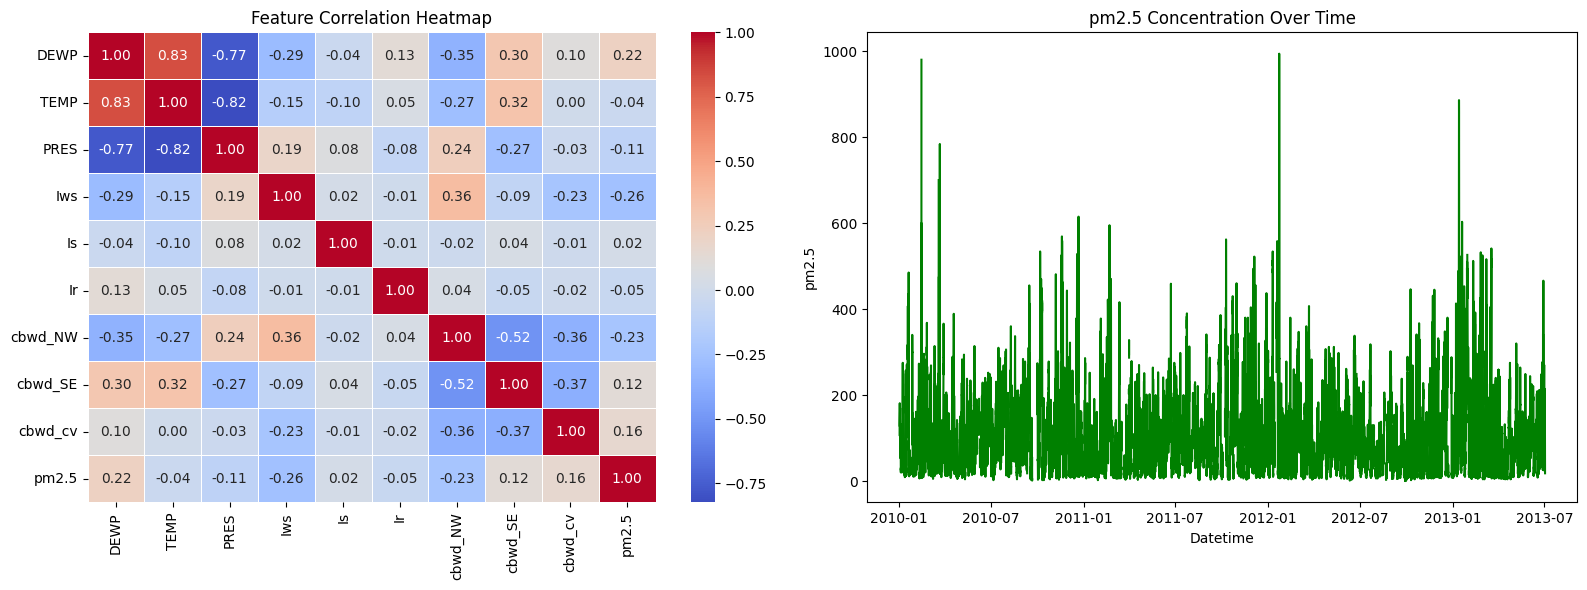

In [11]:
# visualise dataset

def plot_dataset_visuals(df_train):
    plt.figure(figsize=(16, 6))

    # Correlation HeatMap
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
    corr_matrix = df_train.drop(columns=['No']).corr()  # Exclude non-numeric for correlation
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Feature Correlation Heatmap")

    # Line Plot pm2.5 over time
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
    plt.plot(df_train['pm2.5'], color='green')
    plt.title("pm2.5 Concentration Over Time")
    plt.xlabel("Datetime")
    plt.ylabel("pm2.5")

    plt.tight_layout()  # Adjusts subplot params for a tight layout
    plt.show()

# Plot the dataset visuals
plot_dataset_visuals(df_train)

# Handle missing values


- I am using interpolation & forward fill methods to handle the missing values because it's the best for time series forecasting tasks. Mean imputation would break the time series structure that LSTMs need to learn from

In [12]:
# Ensure 'pm2.5' column is numeric
df_train['pm2.5'] = pd.to_numeric(df_train['pm2.5'], errors='coerce')

# Interpolate missing values and then forward-fill and backward-fill any remaining NaNs
df_train['pm2.5'] = df_train['pm2.5'].interpolate(method='linear').ffill().bfill()

print(f"After interpolation + filling: {df_train['pm2.5'].isnull().sum()}")
print("Missing values handling completed!")

After interpolation + filling: 0
Missing values handling completed!


# Seasonal Decomposition

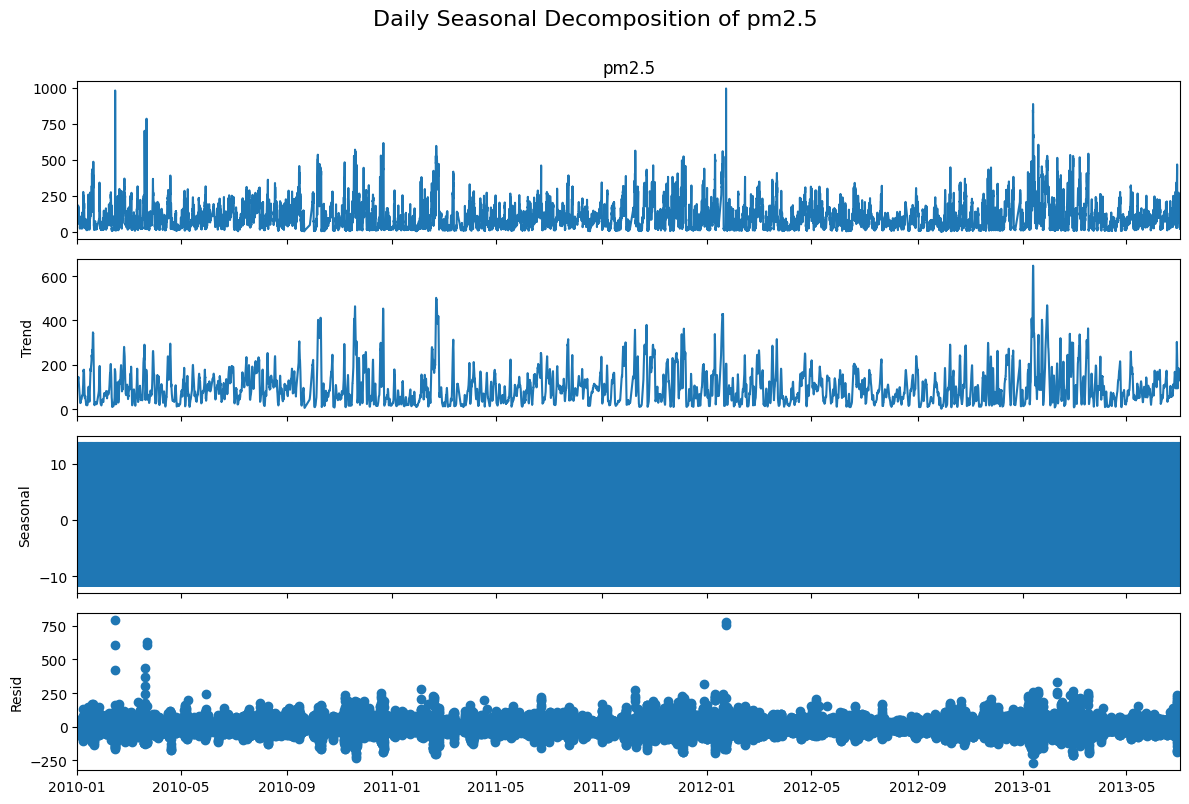

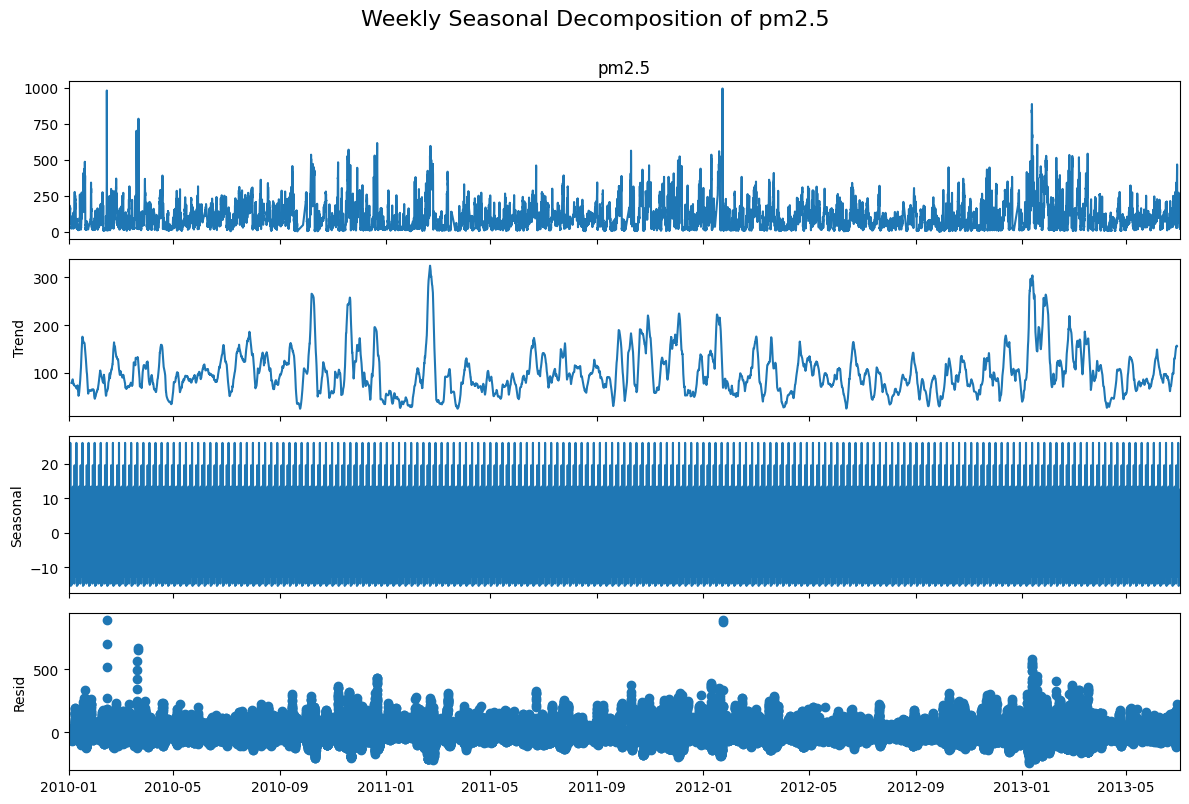

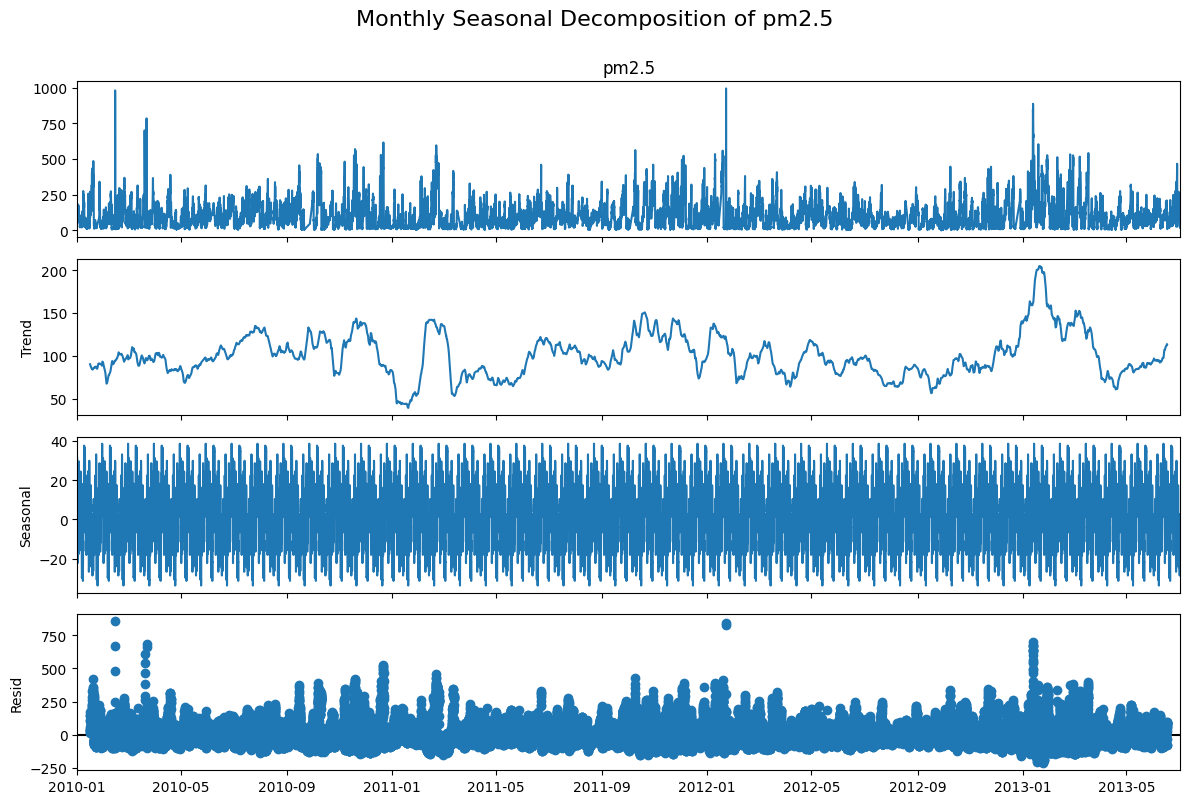

In [13]:
# Perform seasonal decomposition after ensuring no missing values, to understand underlying patterns
# 24 hours, 168 hours (7 days x 24 hours), 720 hours (30 days x 24 hours)

for period, name in [(24, 'Daily'), (168, 'Weekly'), (720, 'Monthly')]:
    result = seasonal_decompose(df_train['pm2.5'], model='additive', period=period)

    # Plot decomposition

    fig = result.plot()
    fig.set_size_inches(12, 8)

    # Set suptitle with vertical position adjusted to avoid overlap
    plt.suptitle(f'{name} Seasonal Decomposition of pm2.5', fontsize=16, y=1)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 1])  # reserve top space for title
    plt.show()

# Temporal Feature Engineering

In [14]:
# Extract components from the datetime index
for df in [df_train, df_test]:
    df['hour'] = df.index.hour  # Access hour from the index
    df['day'] = df.index.day    # Access day from the index
    df['month'] = df.index.month  # Access month from the index
    df['weekday'] = df.index.weekday  # Access weekday from the index
    df['season'] = (df.index.month % 12 + 3) // 3  # Maps months to seasons using the index

# Neural networks struggle with cyclical features like hour/month,
# cyclical encoding as sine/cosine is crucial for them to understand cycles, that hour 23 is close to hour 0
for df in [df_train, df_test]:

    # Hour cyclical encoding (24-hour cycle)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # Month cyclical encoding (12-month cycle)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Day of week cyclical encoding (7-day cycle)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

    # Day of month cyclical encoding (approximate 30-day cycle)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 30)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 30)

    df['is_weekend'] = (df['weekday'] >= 5).astype(int) # Weekend indicator
    df['is_rush_hour'] = ((df['hour'] >= 7) & (df['hour'] <= 9) | (df['hour'] >= 17) & (df['hour'] <= 19)).astype(int) # Rush hours (peak pollution times)
    df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 5)).astype(int) # Night time (lower activity)
    df['is_winter'] = df['month'].isin([12, 1, 2]).astype(int) # Winter months (higher pollution in Beijing)

# Normalization

In [15]:
# Separate features and target
X_train = df_train.drop(['pm2.5', 'No'], axis=1, errors='ignore') # Drop columns not used in training
y_train = df_train['pm2.5']

print(f"Total number of features to be used in model training: {X_train.shape[1]}")
print("Features derived directly from DataFrame):")
print(X_train.columns.tolist())

Total number of features to be used in model training: 26
Features derived directly from DataFrame):
['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'hour', 'day', 'month', 'weekday', 'season', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos', 'day_sin', 'day_cos', 'is_weekend', 'is_rush_hour', 'is_night', 'is_winter']


26 feature columns that will be scaled and used for training;

9 original features (after dropping 'No', 'datetime', 'pm2.5') + 17 engineered features.

# Creating Input-Output Sequences using Time Windowing
To enable our LSTM to learn from temporal patterns, we reshape our training data into sequences. Each sequence consists of 24 previous time steps of features to predict the next PM2.5 value. We standardize both features and target before building these sequences.

In [16]:
# Set target column name if not already set
y_train.name = 'pm2.5'

# Combine features + target in one DataFrame for easier processing
train_full = pd.concat([X_train, y_train], axis=1)

# Standardize features and target
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Fit on entire training data
train_full_scaled = train_full.copy()
train_full_scaled[X_train.columns] = scaler_x.fit_transform(train_full[X_train.columns])
train_full_scaled[y_train.name] = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

# Create sequences with time windowing
def create_sequences(data, target_col, window_size=24):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:i + window_size].drop(columns=[target_col]).values)
        y.append(data.iloc[i + window_size][target_col])
    return np.array(X), np.array(y)

# Set window size
window_size = 24  # 1 day if hourly

# Create input-output sequences
X_seq, y_seq = create_sequences(train_full_scaled, target_col=y_train.name, window_size=window_size)

# Reshape target for compatibility with Keras
y_seq = y_seq.reshape(-1, 1)

Now the input to the model has the shape `(samples, timesteps, features)`, which ensures the LSTM receives proper time series sequences

In [17]:
# Train-test split for validation on sequence data
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42
)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [18]:
# Define input layer (using updated sequence data shape)
input_layer = Input(shape=(X_seq.shape[1], X_seq.shape[2]))
print(f"Input shape: {(X_seq.shape[1], X_seq.shape[2])}")

# First Bidirectional LSTM layer
print("Adding first Bidirectional LSTM layer...")
lstm1 = Bidirectional(LSTM(64,
                          activation='tanh',
                          return_sequences=True,
                          dropout=0.25,
                          recurrent_dropout=0.15))(input_layer)

# Second Bidirectional LSTM layer
print("Adding second Bidirectional LSTM layer...")
lstm2 = Bidirectional(LSTM(32,
                          activation='tanh',
                          return_sequences=True,
                          dropout=0.25,
                          recurrent_dropout=0.15))(lstm1)

# Multi-Head Attention Layer
print("Adding Multi-Head Attention mechanism...")
attention_out = MultiHeadAttention(
    num_heads=4,           # Multiple attention heads for different patterns
    key_dim=16,            # Dimension of attention keys/queries
    dropout=0.1            # Attention dropout for regularization
)(lstm2, lstm2)  # Self-attention: queries and keys from same input

# Residual connection + Layer Normalization
print("Adding residual connection and normalization...")
x = Add()([lstm2, attention_out])  # Skip connection to help training
x = LayerNormalization()(x)        # Normalize for training stability

# Final LSTM layer to process attention output
print("Adding final processing layers...")
final_lstm = Bidirectional(LSTM(16,
                               activation='tanh',
                               return_sequences=False,
                               dropout=0.2))(x)

# Dense layers for final prediction
x = Dense(24, activation='relu')(final_lstm)
x = Dropout(0.15)(x)
output = Dense(1)(x)  # Final prediction

# Create the model
model = Model(inputs=input_layer, outputs=output)

print("Model architecture created successfully!")

Input shape: (24, 26)
Adding first Bidirectional LSTM layer...
Adding second Bidirectional LSTM layer...
Adding Multi-Head Attention mechanism...
Adding residual connection and normalization...
Adding final processing layers...
Model architecture created successfully!


In [19]:
# Compile model with optimized settings
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006),  # using lower LR for stability
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Display the model architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 26)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 24, 128)   │     46,592 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 24, 64)    │     41,216 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 64)    │     16,640 │ bidirectional_1[… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 64)    │          0 │ bidirectional_1[… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 24, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 32)        │     10,368 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 24)        │        792 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 24)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         25 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 115,761 (452.19 KB)

 Trainable params: 115,761 (452.19 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Training Callbacks
# increase the patience for better training since this is a more complex model
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=1e-8, verbose=1),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
]

# Train the Attention model
# increase epochs for such a complex model
history = model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val, y_val),
    epochs=70,          # More epochs for complex model
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/70
384/384 ━━━━━━━━━━━━━━━━━━━━ 99s 201ms/step - loss: 0.9014 - rmse: 0.9475 - val_loss: 0.6255 - val_rmse: 0.7909 - learning_rate: 6.0000e-04
Epoch 2/70
384/384 ━━━━━━━━━━━━━━━━━━━━ 69s 179ms/step - loss: 0.6462 - rmse: 0.8038 - val_loss: 0.5515 - val_rmse: 0.7426 - learning_rate: 6.0000e-04
Epoch 3/70
384/384 ━━━━━━━━━━━━━━━━━━━━ 81s 177ms/step - loss: 0.5812 - rmse: 0.7623 - val_loss: 0.5137 - val_rmse: 0.7167 - learning_rate: 6.0000e-04
Epoch 4/70
384/384 ━━━━━━━━━━━━━━━━━━━━ 67s 173ms/step - loss: 0.5636 - rmse: 0.7506 - val_loss: 0.4918 - val_rmse: 0.7013 - learning_rate: 6.0000e-04
Epoch 5/70
384/384 ━━━━━━━━━━━━━━━━━━━━ 69s 179ms/step - loss: 0.5339 - rmse: 0.7306 - val_loss: 0.4556 - val_rmse: 0.6750 - learning_rate: 6.0000e-04
Epoch 6/70
384/384 ━━━━━━━━━━━━━━━━━━━━ 64s 167ms/step - loss: 0.5065 - rmse: 0.7116 - val_loss: 0.4252 - val_rmse: 0.6520 - learning_rate: 6.0000e-04
Epoch 7/70
384/384 ━━━━━━━━━━━━━━━━━━━━ 87s 179ms/step - loss: 0.4738 - rmse: 0.6883 - val_los

In [21]:
# Predict on train and validation data using sequence-based splits
train_pred = model.predict(X_train_split)
val_pred = model.predict(X_val)

# Inverse transform the predictions and actuals
train_pred_inv = scaler_y.inverse_transform(train_pred)
y_train_inv = scaler_y.inverse_transform(y_train_split.reshape(-1, 1))

val_pred_inv = scaler_y.inverse_transform(val_pred)
y_val_inv = scaler_y.inverse_transform(y_val.reshape(-1, 1))

# Calculate RMSE
train_rmse = np.sqrt(np.mean((y_train_inv - train_pred_inv) ** 2))
val_rmse = np.sqrt(np.mean((y_val_inv - val_pred_inv) ** 2))

print(f'Final Train RMSE: {train_rmse:.2f}')
print(f'Final Validation RMSE: {val_rmse:.2f}')

767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
Final Train RMSE: 30.35
Final Validation RMSE: 37.83


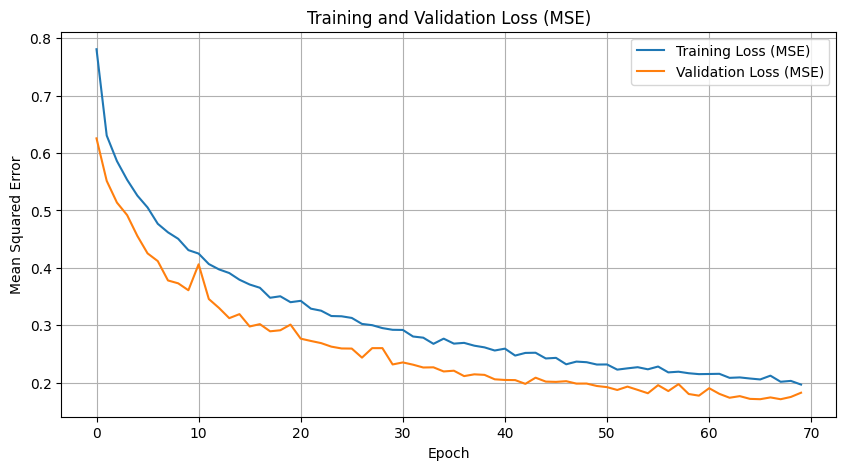

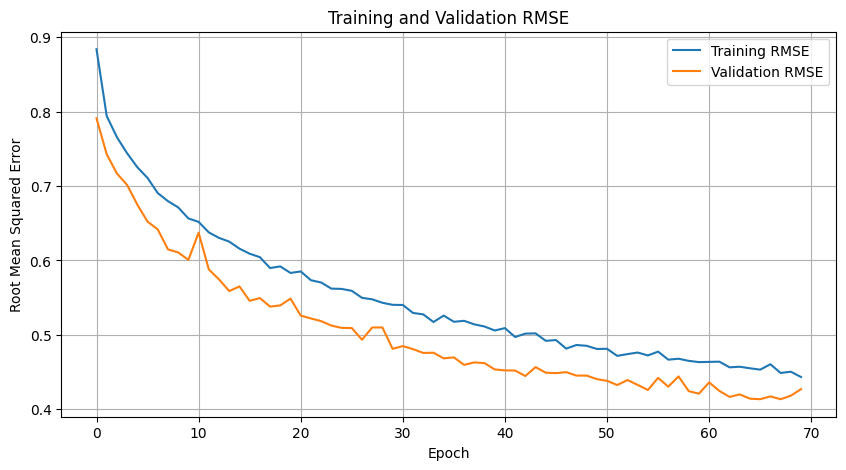

In [22]:
# Plot MSE loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Training and Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

# Plot RMSE over epochs (since you tracked it with metrics=['rmse'])
plt.figure(figsize=(10, 5))
plt.plot(history.history['rmse'], label='Training RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Prediction Visualization
def plot_predictions_vs_actual(y_true, y_pred, title="Predictions vs Actual", sample_size=500):
    """Plot predictions vs actual values"""

    # Sample data for cleaner visualization
    if len(y_true) > sample_size:
        indices = np.random.choice(len(y_true), sample_size, replace=False)
        y_true_sample = y_true[indices]
        y_pred_sample = y_pred[indices]
    else:
        y_true_sample = y_true
        y_pred_sample = y_pred

    plt.figure(figsize=(15, 10))

    # Scatter plot
    plt.subplot(2, 2, 1)
    plt.scatter(y_true_sample, y_pred_sample, alpha=0.5, s=20)
    plt.plot([y_true_sample.min(), y_true_sample.max()],
             [y_true_sample.min(), y_true_sample.max()], 'r--', lw=2)
    plt.xlabel('Actual PM2.5')
    plt.ylabel('Predicted PM2.5')
    plt.title(f'{title} - Scatter Plot')
    plt.grid(True, alpha=0.3)

    # Time series plot (first 200 points)
    plt.subplot(2, 2, 2)
    plot_length = min(200, len(y_true))
    plt.plot(y_true[:plot_length], label='Actual', linewidth=2)
    plt.plot(y_pred[:plot_length], label='Predicted', linewidth=2)
    plt.xlabel('Time Steps')
    plt.ylabel('PM2.5')
    plt.title(f'{title} - Time Series (First 200 points)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Residuals plot
    plt.subplot(2, 2, 3)
    residuals = y_true_sample - y_pred_sample
    plt.scatter(y_pred_sample, residuals, alpha=0.5, s=20)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted PM2.5')
    plt.ylabel('Residuals')
    plt.title('Residuals Plot')
    plt.grid(True, alpha=0.3)

    # Error distribution
    plt.subplot(2, 2, 4)
    plt.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print statistics
    rmse = np.sqrt(np.mean(residuals**2))
    mae = np.mean(np.abs(residuals))
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"Mean Residual: {np.mean(residuals):.2f}")
    print(f"Std Residual: {np.std(residuals):.2f}")

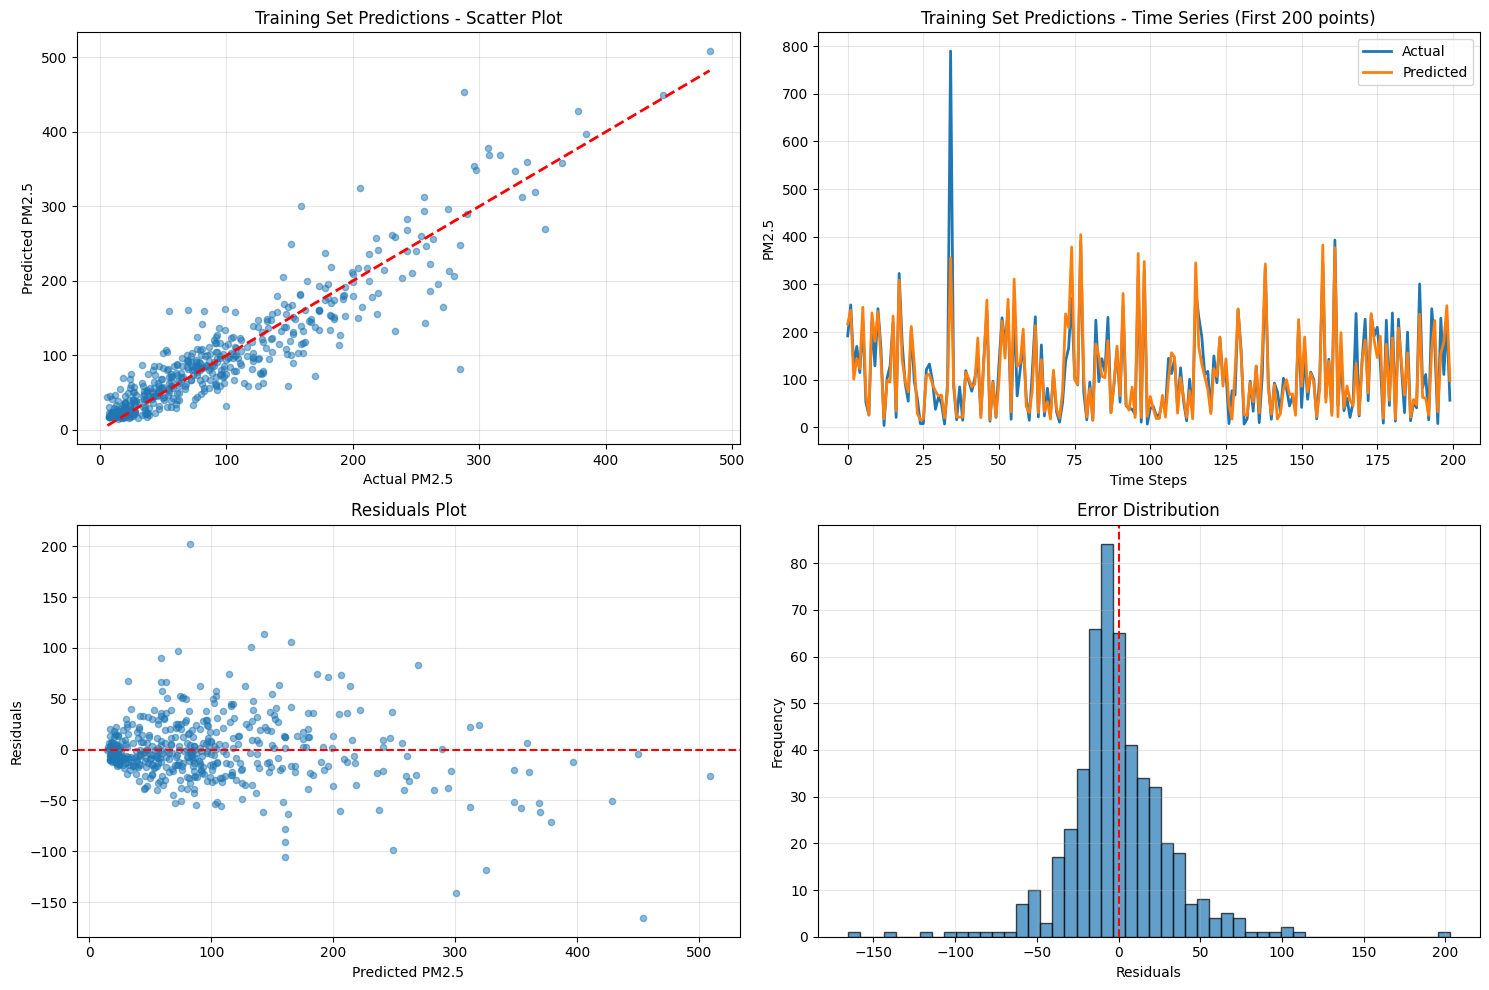

RMSE: 31.64
MAE: 21.66
Mean Residual: -1.07
Std Residual: 31.62


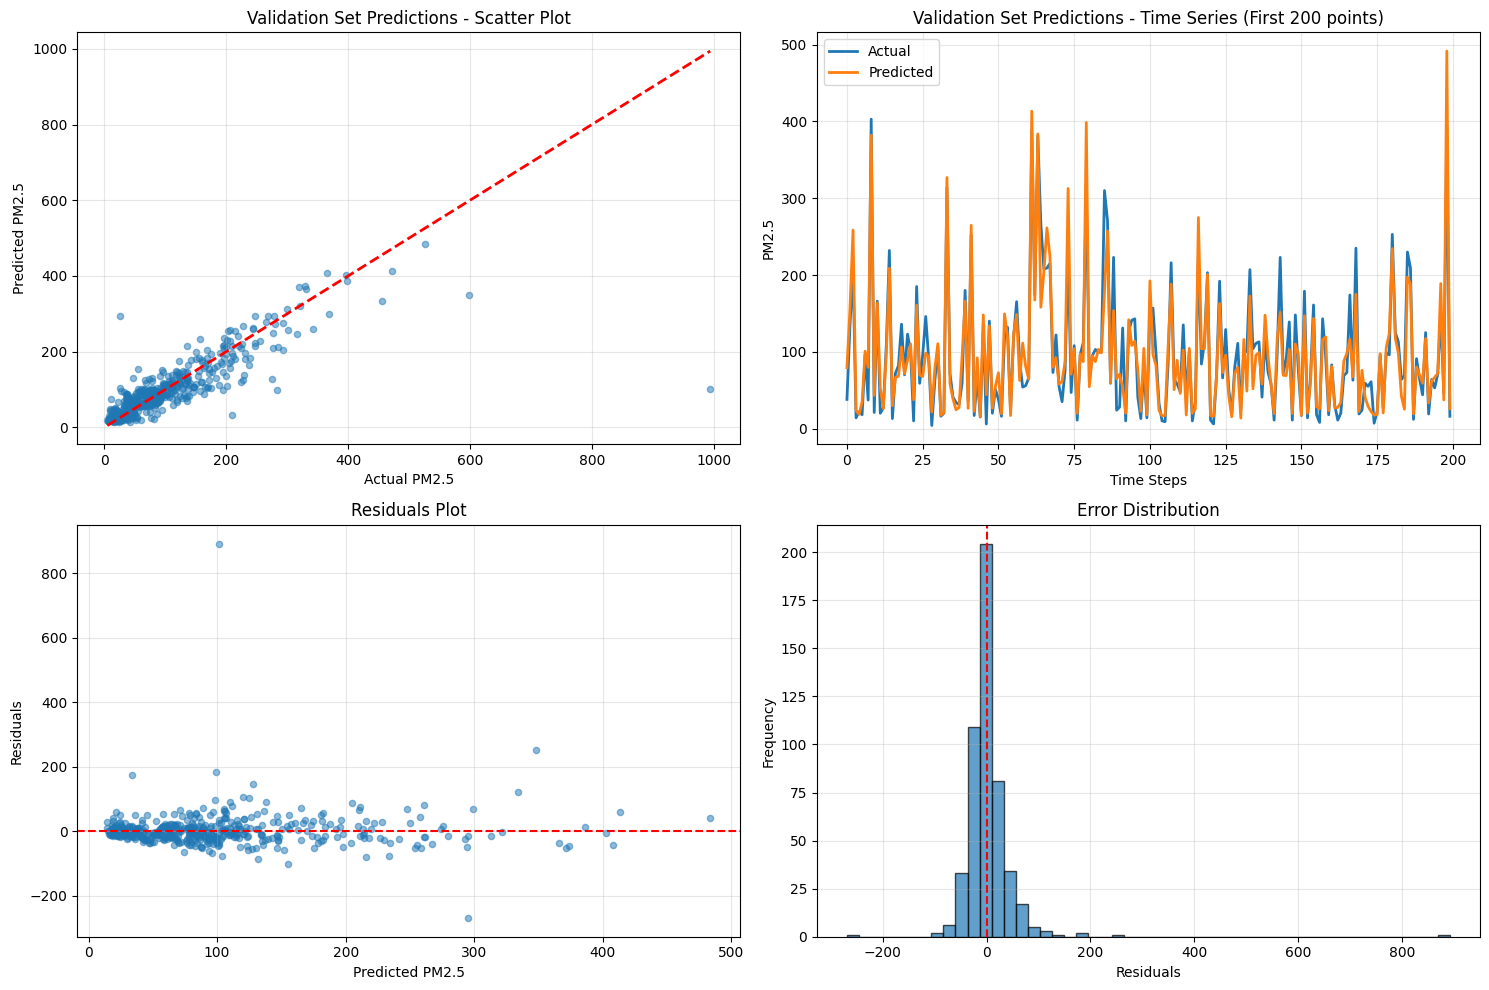

RMSE: 54.04
MAE: 25.41
Mean Residual: 2.22
Std Residual: 53.99


In [28]:
# Plot training predictions
plot_predictions_vs_actual(
    y_train_inv.flatten(),
    train_pred_inv.flatten(),
    "Training Set Predictions"
)

# Plot validation predictions
plot_predictions_vs_actual(
    y_val_inv.flatten(),
    val_pred_inv.flatten(),
    "Validation Set Predictions"
)

In [29]:
# Prepare Test Sequences

# Prepare and scale test data (excluding target)
X_test_raw = df_test.drop(['No', 'pm2.5'], axis=1, errors='ignore')
X_test_scaled = scaler_x.transform(X_test_raw)

# Combine with last portion of training data to form initial window
last_window = train_full_scaled.iloc[-window_size:].drop(columns=[y_train.name]).values
combined_test = np.vstack([last_window, X_test_scaled])

# Create test sequences
X_test_seq = []
for i in range(window_size, len(combined_test)):
    X_test_seq.append(combined_test[i - window_size:i])

X_test_seq = np.array(X_test_seq)

# Predict with trained model
test_predictions = model.predict(X_test_seq)

# Inverse transform to original scale
test_predictions = scaler_y.inverse_transform(test_predictions)

# Clean predictions
test_predictions = np.nan_to_num(test_predictions)
test_predictions = np.clip(test_predictions, 0, np.max(test_predictions))
test_predictions = np.round(test_predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(df_test.index).strftime('%Y-%m-%d %-H:%M:%S'), # Remove leading zeros for hours
    'pm2.5': test_predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Create directory if it doesn't exist
os.makedirs('outputs', exist_ok=True)

# Save the file in CSV format for submission on Kaggle
submission.to_csv('outputs/submission.csv', index=False)

print("Test predictions saved to outputs/submission.csv")

411/411 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step
Test predictions saved to outputs/submission.csv


In [30]:
pip install --upgrade kaggle

In [31]:
""" Submitting to Kaggle """

# Create submission CSV file with predictions

# Submit to Kaggle
!kaggle competitions submit -c assignment-1-time-series-forecasting-may-2025 -f outputs/submission.csv -m "Test Submission"

100% 295k/295k [00:01<00:00, 246kB/s]
Successfully submitted to Assignment 1- Time Series Forecasting May 2025